# Vertical profiles at the terminators

In [1]:
import warnings

warnings.filterwarnings("ignore")  # noqa

In [2]:
from tqdm.notebook import tqdm

In [3]:
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# My packages and local scripts
from aeolus.calc import meridional_mean, time_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.core import AtmoSim
from aeolus.io import load_data
from aeolus.model import um
from aeolus.plot import add_custom_legend, subplot_label_generator, tex2cf_units

In [5]:
from pouch.path import lsdir
from pouch.plot import KW_MAIN_TTL, KW_SBPLT_LABEL, KW_ZERO_LINE, figsave, use_style

In [6]:
import mypaths
from commons import GLM_SUITE_ID, NIGHTSIDE, OPT_LABELS, SIM_LABELS, SUITE_LABELS

In [7]:
use_style()

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])

In [8]:
TERMINATORS = {
    "west_term": {
        "constraint": iris.Constraint(**{um.x: -90}),
        "title": "Western (morning) terminator",
        "label": "west_term",
        "kw_plt": dict(linestyle="-"),
    },
    "east_term": {
        "constraint": iris.Constraint(**{um.x: 90}),
        "title": "Eastern (evening) terminator",
        "label": "east_term",
        "kw_plt": dict(linestyle="--"),
    },
}

In [9]:
img_prefix = f"{GLM_SUITE_ID}_mean"
# time_prof = "mean_days6000_9950"
plotdir = mypaths.plotdir / img_prefix

In [10]:
# Load processed data
runs = {}
for suite_label, suite_prop in tqdm(SUITE_LABELS.items()):
    top_label = f"{GLM_SUITE_ID}_{suite_label}"
    planet = suite_prop["planet"]
    const = init_const(planet, directory=mypaths.constdir)
    procdir = mypaths.sadir / top_label
    for opt_label in tqdm(OPT_LABELS.keys(), leave=False):
        sim_label = f"{suite_label}_{opt_label}"
        if sim_label not in SIM_LABELS.keys():
            continue
        if opt_label == "base":
            time_prof = "mean_days6000_9950"
        elif sim_label == "grcs_sens-noradcld":
            time_prof = "mean_days2000_2200"
        else:
            time_prof = "mean_days2000_2950"
        cl = load_data(
            files=procdir / f"{top_label}_{opt_label}_{time_prof}.nc",
        )

        add_planet_conf_to_cubes(cl, const)
        # Use the cube list to initialise an AtmoSim object
        runs[sim_label] = AtmoSim(
            cl,
            name=sim_label,
            planet=planet,
            const_dir=mypaths.constdir,
            timestep=cl[0].attributes["timestep"],
            model=um,
        )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [11]:
Z_VRBL_PLOT = {
    "temp": {
        "title": "Air temperature",
        "cube": lambda cl: cl.extract_cube(um.temp),
        "kw_plt": dict(linestyle="-"),
        "tex_units": "$K$",
        "xlim": [170, 270],
        "inset_bounds": [0.5, 0.5, 0.475, 0.45],
        "inset_xlim": [200, 265],
    },
    "sh": {
        "title": "Specific humidity",
        "cube": lambda cl: cl.extract_cube(um.sh),
        "kw_plt": dict(linestyle="-"),
        "tex_units": "$kg$ $kg^{-1}$",
        "xlim": [1e-8, 1e-2],
        "xscale": "log",
        "inset_bounds": [0.5, 0.5, 0.475, 0.45],
        "inset_xlim": [1e-5, 2e-3],
    },
    "cld_liq_mf": {
        "title": "Liquid water mass mixing ratio",
        "cube": lambda cl: cl.extract_cube(um.cld_liq_mf),
        "kw_plt": dict(linestyle="-"),
        "tex_units": "$kg$ $kg^{-1}$",
        "xlim": [1e-11, 1e-5],
        "xscale": "log",
        "inset_bounds": [0.5, 0.5, 0.475, 0.45],
        "inset_xlim": [1e-8, 3e-6],
    },
    "cld_ice_mf": {
        "title": "Ice water mass mixing ratio",
        "cube": lambda cl: cl.extract_cube(um.cld_ice_mf),
        "kw_plt": dict(linestyle="-"),
        "tex_units": "$kg$ $kg^{-1}$",
        "xlim": [1e-11, 1e-5],
        "xscale": "log",
        "inset_bounds": [0.5, 0.5, 0.475, 0.45],
        "inset_xlim": [1e-8, 8e-6],
    },
}

In [12]:
RESULTS = {}
for sim_label in SIM_LABELS.keys():
    the_run = runs[sim_label]
    RESULTS[sim_label] = {}
    for (vrbl_key, vrbl_dict) in Z_VRBL_PLOT.items():
        RESULTS[sim_label][vrbl_key] = {}
        for term_key, term_dict in TERMINATORS.items():
            cube = time_mean(
                meridional_mean(
                    vrbl_dict["cube"](the_run._cubes).extract(
                        term_dict["constraint"]
                    )
                )
            )
            cube.convert_units(tex2cf_units(vrbl_dict["tex_units"]))
            RESULTS[sim_label][vrbl_key][term_key] = cube

In [13]:
# ylim_inset = 1000, 100
# yticks_inset = 1000, 750, 500, 250

# kw_ax_set = dict(
#     yscale="log",
#     ylabel="Pressure [$hPa$]",
#     ylim=[1000, 0.01],
#     yticks=[1000, 100, 10, 1, 0.1],
# )

kw_ax_set = dict(
    yscale="linear",
    ylabel="Altitude [$km$]",
    ylim=[0, 80],
)
kw_axins_set = dict(
    yscale="linear", ylim=[0, 10], yticks=np.arange(0, 10, 2, dtype=int)
)

Saved to ../plots/ch111_mean/ch111_mean__vprof_term__grcs_base_grcs_sens-t280k__temp_sh_cld_liq_mf_cld_ice_mf.png


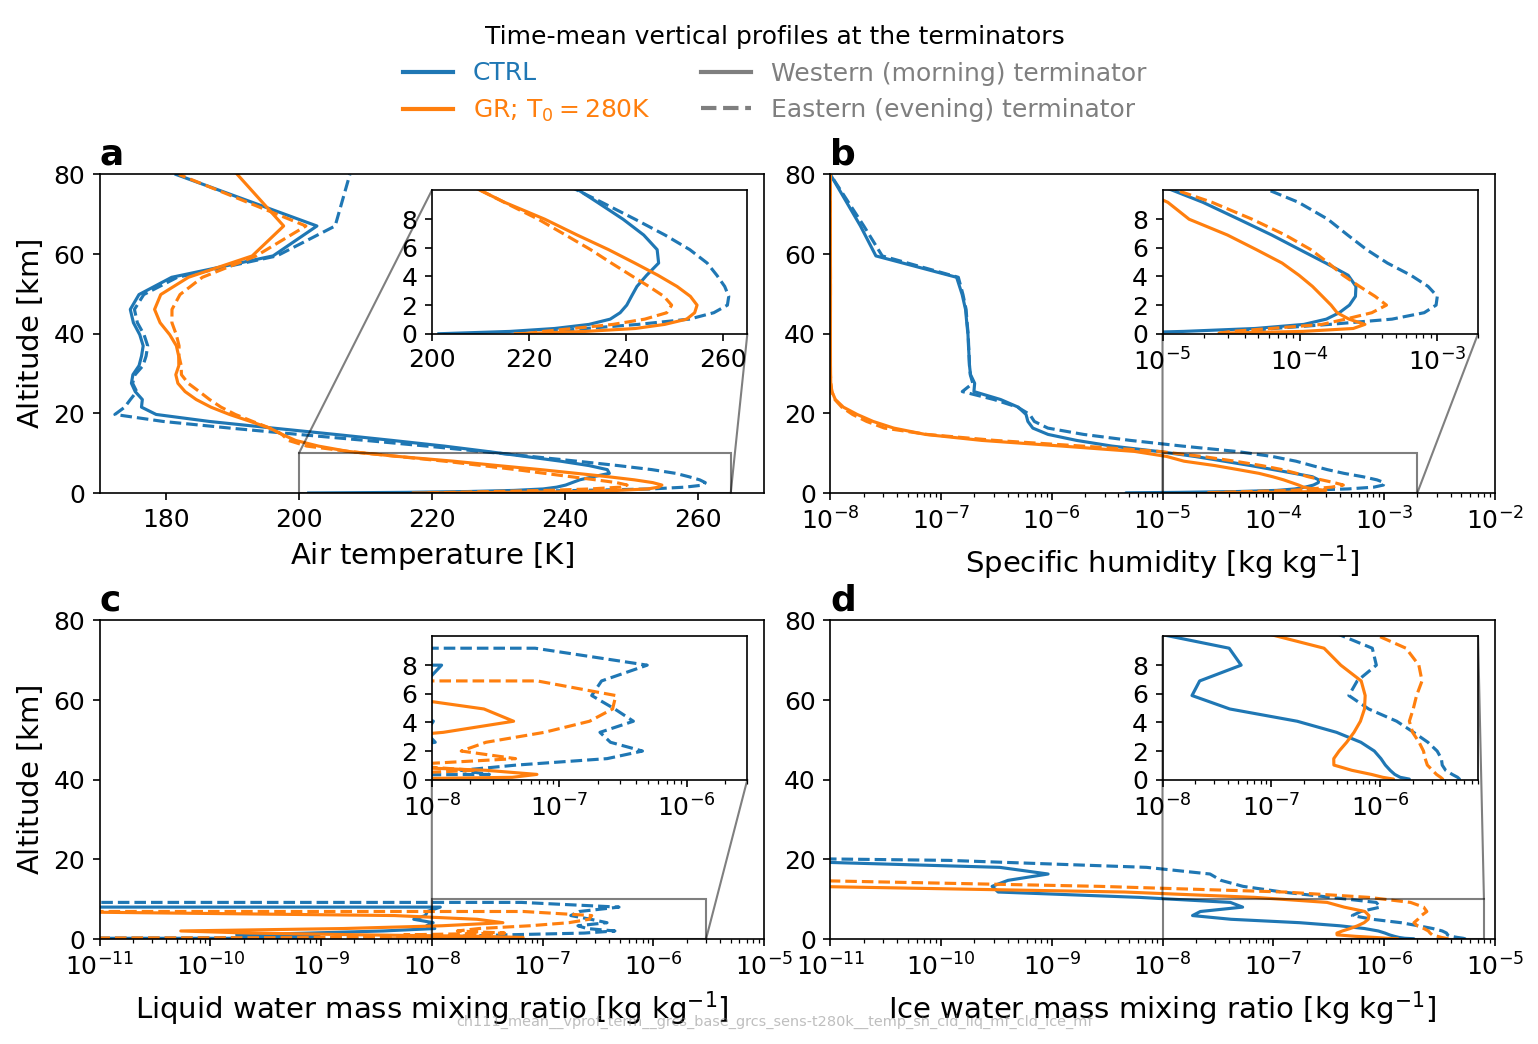

In [14]:
imgname = f"{img_prefix}__vprof_term__{'_'.join(SIM_LABELS.keys())}__{'_'.join(Z_VRBL_PLOT.keys())}"
kw_plt_common = {}  # marker=".", ms=3,

fig = plt.figure()
axd = fig.subplot_mosaic(
    [[*Z_VRBL_PLOT.keys()][i : i + 2] for i in range(0, 4, 2)],
    gridspec_kw={"wspace": 0.1, "hspace": 0.4},
)
iletters = subplot_label_generator()
for (vrbl_key, vrbl_dict) in Z_VRBL_PLOT.items():
    ax = axd[vrbl_key]
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set(
        xscale=vrbl_dict.get("xscale", "linear"),
        xlim=vrbl_dict.get("xlim"),
        xlabel=f"{vrbl_dict['title']} [{vrbl_dict['tex_units']}]",
        **kw_ax_set,
    )
    if not ax.get_subplotspec().is_first_col():
        ax.set(ylabel="")
    axins = ax.inset_axes(vrbl_dict["inset_bounds"])
    axins.set(
        xscale=vrbl_dict.get("xscale", "linear"),
        xlim=vrbl_dict.get("inset_xlim"),
        **kw_axins_set,
    )
    ax.indicate_inset_zoom(axins, edgecolor="black")
    if np.sign(vrbl_dict["xlim"][0]) != np.sign(vrbl_dict["xlim"][1]):
        ax.axvline(**KW_ZERO_LINE)
        axins.axvline(**KW_ZERO_LINE)
    for (sim_label, sim_prop) in SIM_LABELS.items():
        for term_key, term_dict in TERMINATORS.items():
            cube = RESULTS[sim_label][vrbl_key][term_key]
            y = cube.coord(um.z).points * 1e-3
            # y = (
            #     1e-2
            #     * time_mean(
            #         meridional_mean(runs[sim_label].pres.extract(term_dict["constraint"]))
            #     ).data
            # )
            ax.plot(
                cube.data,
                y,
                **kw_plt_common,
                **sim_prop["kw_plt"],
                **term_dict["kw_plt"],
            )
            axins.plot(
                cube.data,
                y,
                **kw_plt_common,
                **sim_prop["kw_plt"],
                **term_dict["kw_plt"],
            )

add_custom_legend(
    fig,
    {
        **{
            v["title"]: {"linestyle": "-", "linewidth": 2, **v["kw_plt"]}
            for v in SIM_LABELS.values()
        },
        **{
            v["title"]: {"color": "tab:grey", "linewidth": 2, **v["kw_plt"]}
            for v in TERMINATORS.values()
        },
    },
    loc="upper center",
    frameon=False,
    ncol=2,
    fontsize="medium",
    title="Time-mean vertical profiles at the terminators",
    bbox_to_anchor=(0.5, 1.05),
)
figsave(fig, plotdir / imgname)